# Simulating SC/KAB Lennard-Jones with rumdpy 

Features included:
- choice between several integrators
- cooling ramp giving insight into phase behavior
- on-the-fly 3D visualization

In [1]:
# Reproducing 'ATU' run in phd1:
#    LJ, N=864, rho=0.60, cooling from T=3.0 to 0.1 with dt=0.005, 
#    scalars: every 20'th step, trajectory: 194 log-blocks    
#
# Timestep                                       200_000            2_000_000
# Rumd3 GeForce GTX TITAN, 5.5 TFlops, runtime: 56   sec            196   sec ( 121 conf_blocks * 285 Kb)       rumd_rdf: 14s, rumd_msd: 7s
# rumdpy RTX 3070 Laptop, 11.4 TFlops, runtime: 10.0 sec (256_000)   39.9 sec (1000 conf_blocks * 257/167z Kb)  on-the-fly     ~1s 

## Imports

In [2]:
import numpy as np
import numba
import math
from numba import cuda

# rumdpy
import rumdpy as rp
from rumdpy.integrators import nve, nve_toxvaerd, nvt, nvt_langevin, npt_langevin
from analyze_LJ import analyze_LJ

# IO
import pandas as pd
import pickle
import sys
import h5py

# Plotting and visualization
import matplotlib.pyplot as plt
#%matplotlib inline
#%matplotlib notebook
%matplotlib widget

import k3d
from k3d.colormaps import matplotlib_color_maps
import ipywidgets as widgets

In [3]:
print(numba.__version__)

0.55.1


## Generate configuration with a FCC lattice

In [4]:
include_KABLJ = True

c1 = rp.make_configuration_fcc(nx=6,  ny=6,  nz=6,  rho=0.60,  T=3.44)      # N = 4*6**3   =  864
#c1 = rp.make_configuration_fcc(nx=8,  ny=8,  nz=8,  rho=0.60,  T=3.44)      # N = 4*6**3   =  864
#c1 = rp.make_configuration_fcc(nx=16,  ny=4,  nz=4,  rho=0.60,  T=3.44)    # N = 4*18*6*6 = 2592

if include_KABLJ:
    c1.ptype[np.arange(0,c1.N,5)] = 1    # 4:1 mixture
c1.copy_to_device() 

# Get a 'compute-plan', i.e. parameters determining how simulations are performed on the GPU
compute_plan = rp.get_default_compute_plan(c1)
print('compute_plan:', compute_plan)

compute_plan: {'pb': 8, 'tp': 16, 'skin': 0.5, 'UtilizeNIII': False, 'gridsync': True}


## Setup Lennard-Jones pair potential

In [6]:
pair_potential = rp.apply_shifted_force_cutoff(rp.make_LJ_m_n(12,6))
sigma =   [[1.00, 0.80], 
           [0.80, 0.88]] # Setting up KABLJ. If all particles are type 0, 
epsilon = [[1.00, 1.50], 
           [1.50, 0.50]] # ... this reverts to single componant LJ
cutoff = np.array(sigma)*2.5
params = rp.LJ_12_6_params_from_sigma_epsilon_cutoff(sigma, epsilon, cutoff)
LJ = rp.PairPotential(c1, pair_potential, params=params, max_num_nbs=1000, compute_plan=compute_plan)
pairs = LJ.get_interactions(c1, exclusions=None, compute_plan=compute_plan, verbose=False)

## Setup output managers

In [9]:
steps_between_output = 16
output_calculator = rp.make_scalar_calculator(c1, steps_between_output, compute_plan)

conf_saver = rp.make_conf_saver(c1, compute_plan)

## Setup RDF (Radial Distribution Function) calculator

In [10]:
include_rdf = True
if include_rdf:
    num_bins = 500
    full_range=True
    gr_bins_zeros = np.zeros(num_bins, dtype=np.float64) # float64 good / necessary
    d_gr_bins = cuda.to_device(gr_bins_zeros)
       
    rdf_calculator = rp.make_rdf_calculator(c1, pair_potential = LJ, compute_plan=compute_plan, full_range=full_range, verbose=True)  

## Setup integrator

In [11]:
integrator = 'NVT'

dt = 0.005 # timestep (MOVE from setup to call)
outer_steps = 1000   # Do simulation in this many 'blocks'
inner_steps = 2*1024  # ... each of this many steps
#inner_steps = 256  # ... each of this many steps
running_time = dt*inner_steps*outer_steps

Thigh = 2.00
Tlow  = 0.25

# Setup functions to control temperature and pressure (only for NPT)
T0 = rp.make_function_constant(value=Thigh) # Not used for NVE*
P0 = rp.make_function_constant(value=0.0) # Not used for NV*
T1 = rp.make_function_ramp(value0=Thigh, x0=running_time*(1/4), value1=Tlow, x1=running_time*(3/4))

In [12]:
# Integrator for equilibration
integrate0, integrator_params0 = nvt.setup_output(c1, pairs['interactions'], None, None, T0, tau=0.2, dt=dt, compute_plan=compute_plan, verbose=False) 

# Interrator for production
if integrator=='NVE':
    integrate, integrator_params = nve.setup_output(c1, pairs['interactions'], output_calculator, dt=dt, compute_plan=compute_plan, verbose=False)

if integrator=='NVE_Toxvaerd':
    integrate, integrator_params = nve_toxvaerd.setup_output(c1, pairs['interactions'], output_calculator, dt=dt, compute_plan=compute_plan, verbose=False)

if integrator=='NVT':
    integrate, integrator_params = nvt.setup_output(c1, pairs['interactions'], output_calculator, conf_saver, T1, tau=0.2, dt=dt, compute_plan=compute_plan, verbose=False) 
        
if integrator=='NVT_Langevin':
    integrate, integrator_params = nvt_langevin.setup_output(c1, pairs['interactions'], output_calculator, T1, alpha=0.1, dt=dt, seed=2023, compute_plan=compute_plan, verbose=False)

if integrator=='NPT_Langevin':
    integrate, integrator_params = npt_langevin.setup_output(c1, pairs['interactions'],  output_calculator, T1, P0, alpha=0.1, alpha_baro=0.0001, 
        mass_baro=0.0001, volume_velocity=0.0, barostatModeISO = True , boxFlucCoord = 2, dt=dt, seed=2023, compute_plan=compute_plan, verbose=False)


In [99]:
class simulation():
    def __init__(self, conf, integrator, dt, interactions, num_blocks, steps_per_block, steps_between_output, include_rdf=False, storage='hdf5', filename='output'):
        self.conf = conf
        self.integrator = integrator
        self.dt = dt
        self.interactions = interactions
        self.num_blocks = num_blocks
        self.steps_per_block = steps_per_block
        self.steps_between_output = steps_between_output
        self.include_rdf = include_rdf
        self.storage = storage
        self.filename = filename
        
        # per block storage of configuration
        self.conf_per_block = int(math.log2(steps_per_block))+2 # Should be user controlable
        self.num_vectors = 2 # 'r' and 'r_im'
        print('Configurations per block (log2-storing):', self.conf_per_block)
        self.zero_conf_array = np.zeros((self.conf_per_block, self.num_vectors, self.conf.N, self.conf.D), dtype=np.float32)
        self.d_conf_array = cuda.to_device(self.zero_conf_array)
        
        # per block storage of scalars
        self.zero_output_array = np.zeros((self.steps_per_block//self.steps_between_output, 5), dtype=np.float32)
        self.d_output_array = cuda.to_device(self.zero_output_array) 
            
        if self.storage=='hdf5':
            print('Saving results in hdf5 format. Filename:', filename+'.h5')
            with h5py.File(filename+'.h5', "w", libver="latest") as f:
                #dset = f.create_dataset("block", shape=(self.num_blocks, self.conf_per_block, self.num_vectors, self.conf.N, self.conf.D), 
                #                        chunks=(1, 1, self.num_vectors, self.conf.N, self.conf.D), dtype=np.float32, compression="gzip")
                dset = f.create_dataset("block", shape=(self.num_blocks, self.conf_per_block, self.num_vectors, self.conf.N, self.conf.D), 
                                        chunks=(1, 1, self.num_vectors, self.conf.N, self.conf.D), dtype=np.float32)
        elif self.storage=='memory':
            print(f'Storing results in memory. Expected footprint {self.num_blocks*self.conf_per_block*self.num_vectors*self.conf.N*self.conf.D*4/1024/1024:.2f} MB.')
            # allocation delayed until beginning of run to let user reconsider
        else:
            print("WARNING: Results will not be stored. To change this use storage='hdf5' or 'memory'")

            
    def run(self):
        if self.storage=='memory':
            self.conf_blocks = np.zeros((self.num_blocks, self.conf_per_block, self.num_vectors, self.conf.N, self.conf.D), dtype=np.float32)
        
        tt = []
        conf_list = []
        scalars_t = []
        start = cuda.event()
        end = cuda.event()
        zero = np.float32(0.0)
        start.record()
        
        for block in range(self.num_blocks):
 
            self.d_output_array = cuda.to_device(self.zero_output_array) # Set output array to zero. Could probably be done faster
            self.integrator[0](self.conf.d_vectors, self.conf.d_scalars, self.conf.d_ptype, self.conf.d_r_im, self.conf.simbox.d_data,  
                                 self.interactions['interaction_params'], self.integrator[1], 
                                 self.d_output_array, self.d_conf_array, 
                                 np.float32(block*self.steps_per_block*self.dt), self.steps_per_block)
        
            scalars_t.append(self.d_output_array.copy_to_host())        
            
            if self.storage=='hdf5':
                with h5py.File(self.filename+".h5", "a") as f:
                    f['block'][block,:] = self.d_conf_array.copy_to_host()
            elif self.storage=='memory':
                self.conf_blocks[block] = self.d_conf_array.copy_to_host()
                
            #vol = (c1.simbox.data[0] * c1.simbox.data[1] * c1.simbox.data[2])
            #vol_t.append(vol)

            if self.include_rdf:
                rdf_calculator(c1.d_vectors, c1.simbox.d_data, c1.d_ptype, pairs['interaction_params'], d_gr_bins)
                gr_bins.append(d_gr_bins.copy_to_host())
                d_gr_bins = cuda.to_device(gr_bins_zeros)

            yield block
    
        # Finalizing run
        end.record()
        end.synchronize()
    
        self.timing_numba = cuda.event_elapsed_time(start, end)
        self.nbflag = LJ.nblist.d_nbflag.copy_to_host()    
    
    def print_summary(self):
        tps = self.num_blocks*self.steps_per_block/self.timing_numba*1000
        print('\tsteps :', self.num_blocks*self.steps_per_block)
        print('\tnbflag : ', self.nbflag)
        print('\ttime :', self.timing_numba/1000, 's')
        print('\tTPS : ', tps )
            

In [100]:
sim = simulation(c1, (integrate, integrator_params), dt, pairs, outer_steps, inner_steps, 16, include_rdf=False, storage='memory', filename='temp')

Configurations per block (log2-storing): 13
Storing results in memory. Expected footprint 257.08 MB.


In [101]:
for block in sim.run():
    if block%100==0:
        print(block)

0
100
200
300
400
500
600
700
800
900


In [98]:
# memory
sim.print_summary()

	steps : 2048000
	nbflag :  [     0      0 799729]
	time : 37.37060546875 s
	TPS :  54802.43026066505


In [102]:
# hdf5
sim.print_summary()

	steps : 2048000
	nbflag :  [     0      0 953198]
	time : 37.4368046875 s
	TPS :  54705.52353747805


In [91]:
# hdf5 gzip
sim.print_summary()

	steps : 2048000
	nbflag :  [     0      0 646186]
	time : 42.59358203125 s
	TPS :  48082.36129324428


In [92]:
!ls -l 

total 176064
-rw-rw-r-- 1 tbs tbs       641 Jan  1 20:10 analyze_LJ.py
-rw-rw-r-- 1 tbs tbs     17652 Sep  7 18:03 colarray.ipynb
drwxrwxr-x 3 tbs tbs      4096 Jan 22 10:53 Data
-rw-rw-r-- 1 tbs tbs      9585 Dec 21 10:37 LJchain_wall.py
-rw-rw-r-- 1 tbs tbs    558114 Jan 22 16:56 LJoutput2.ipynb
-rw-rw-r-- 1 tbs tbs    552403 Jan 22 15:09 LJoutput.ipynb
-rw-rw-r-- 1 tbs tbs      9001 Jan  9 03:04 LJoutput.py
-rw-rw-r-- 1 tbs tbs      5520 Dec 21 13:48 LJ.py
-rw-rw-r-- 1 tbs tbs      5010 Dec 14 10:42 LJ.py~
drwxrwxr-x 2 tbs tbs      4096 Jan  2 11:58 __pycache__
-rw-rw-r-- 1 tbs tbs 179092377 Jan 22 16:57 temp.h5
-rw-rw-r-- 1 tbs tbs       500 Dec  1 14:42 write_to_lammps.py


## Initialize storing output

In [13]:
memory_blocks = True
hdf5_blocks = True
hdf5virtual_blocks = True

conf_per_block = int(math.log2(inner_steps))+2 # carefull!!!
num_vectors = 2 # 'r' and 'r_im'

print('Configurations per block (log2-storing):', conf_per_block)

if memory_blocks:
    print(f'Storing conf blocks in memory. Expected footprint {outer_steps*conf_per_block*num_vectors*c1.N*c1.D*4/1024/1024:.2f} MB.')
    conf_blocks = np.zeros((outer_steps, conf_per_block, num_vectors, c1.N, c1.D), dtype=np.float32)
    print(f'Allocated: {conf_blocks.nbytes/1024/1024:.2f} MB.')

if hdf5_blocks:
    with h5py.File("Data/LJ_trajectory.h5", "w", libver="latest") as f:
        #dset = f.create_dataset("block", shape=(outer_steps, conf_per_block, num_vectors, c1.N, c1.D,), chunks=(1, 1, num_vectors, c1.N, c1.D), dtype=np.float32)
        dset = f.create_dataset("block", shape=(outer_steps, conf_per_block, num_vectors, c1.N, c1.D,), chunks=(1, 1, num_vectors, c1.N, c1.D), dtype=np.float32, compression="gzip")
        #dset = f.create_dataset("block", shape=(outer_steps, conf_per_block, num_vectors, c1.N, c1.D,), dtype=np.float32)
        
if hdf5virtual_blocks:
    # Assemble virtual dataset
    # modified from: https://github.com/h5py/h5py/blob/master/examples/vds_simple.py
    layout = h5py.VirtualLayout(shape=(outer_steps, conf_per_block, num_vectors, c1.N, c1.D), dtype=np.float32)
    for n in range(outer_steps):
        filename = f"Data/LJ_trajectory/conf_block_{n:05d}.h5"
        layout[n] = h5py.VirtualSource(filename, "block", shape=(conf_per_block, num_vectors, c1.N, c1.D,))
    
    # Add virtual dataset to output file
    with h5py.File("Data/LJ_trajectory_vir.h5", "w", libver="latest") as f:
        f.create_virtual_dataset("block", layout, fillvalue=0)
        

    

Configurations per block (log2-storing): 13
Storing conf blocks in memory. Expected footprint 257.08 MB.
Allocated: 257.08 MB.


## Initialize 3D visualization

In [36]:
plt_points = k3d.points(positions=c1['r'],
                        point_sizes=np.ones((c1.N),dtype=np.float32),
                        #shader='3dSpecular',
                        #shader='3d',
                        shader='mesh',
                        color_map=matplotlib_color_maps.Jet,
                        attribute=c1.scalars[:,0],
                        color_range=[-6, 0],
                        name='Atoms'
                       )
Lx, Ly, Lz = c1.simbox.data
plt_box = k3d.lines(vertices=[[-Lx/2, -Ly/2, -Lz/2], [-Lx/2, -Ly/2, +Lz/2], 
                              [-Lx/2, +Ly/2, -Lz/2], [+Lx/2, -Ly/2, -Lz/2], 
                              [-Lx/2, +Ly/2, +Lz/2], [+Lx/2, -Ly/2, +Lz/2], 
                              [+Lx/2, +Ly/2, -Lz/2], [+Lx/2, +Ly/2, +Lz/2]], 
                    indices=[[0,1], [0,2], [0,3], 
                            [1,4], [1,5], [2,4], [2,6], [3,5], [3,6],
                            [7,4], [7,5], [7,6]], 
                    indices_type='segment',
                    shader='mesh', width=min((Lx, Ly, Lz))/100, 
                    name='Simulation Box'
                   )


plt_time_text = k3d.text2d('Time: ', position=[0.01, 0.15], is_html=True)
plt_temp_text = k3d.text2d('Temperature: ', position=[0.01, 0.25], is_html=True,)
plt_fn_text = k3d.text2d('Potential:', position=[0.01, 0.42], is_html=True)

plot = k3d.plot(camera_mode='orbit', camera_fov=3.0,)
plot += plt_points
plot += plt_box
plot += plt_fn_text + plt_time_text + plt_temp_text
#plot.display()

In [37]:
def update_3D(index, choice):
    plt_points.positions = conf_list[index]
    model_time = (index+1)*dt*inner_steps
    plt_time_text.text = f'Time: {model_time:.2f}'
    plt_temp_text.text = f'Temp: {T1(model_time):.3f}'
    if choice==6:
        plt_points.attribute = c1.ptype
    else:
        plt_points.attribute = scalars_list[index][:,choice]
    Lx, Ly, Lz = c1.simbox.data
    plt_box.vertices=[[-Lx/2, -Ly/2, -Lz/2], [-Lx/2, -Ly/2, +Lz/2], 
                      [-Lx/2, +Ly/2, -Lz/2], [+Lx/2, -Ly/2, -Lz/2], 
                      [-Lx/2, +Ly/2, +Lz/2], [+Lx/2, -Ly/2, +Lz/2], 
                      [+Lx/2, +Ly/2, -Lz/2], [+Lx/2, +Ly/2, +Lz/2]],
    
def set_color_range(choice):
    labels = {0:'Potential:', 1:'Virial:', 2:'Laplace U:', 3:'m:', 4:'Kinetic nrg:', 5:'F^2', 6:'Type'}
    plt_fn_text.text = labels[choice]
    if choice == 6:
        minval, maxval = np.min(c1.ptype), np.max(c1.ptype)
    else:
        minval, maxval = np.percentile(scalars_list[:,:,choice], (1, 99))
    if minval==maxval:
        minval -= abs(minval*.1)
        maxval += abs(maxval*.1)
    plt_points.color_range = (minval, maxval)
        
play = widgets.Play(
    value=outer_steps-1,
    min=0,
    max=outer_steps-1,
    step=1,
    interval=0,
    description="Press play",
    disabled=False
)

attribute_dropdown = widgets.Dropdown(
    options=[('Potential energy', 0), ('Virial', 1), ('Laplace U', 2), ('m', 3), ('Kinetic energy', 4), ('F^2', 5), ('Type', 6)],
    value=0,
    description='Color:',
    disabled=False,
)

slider = widgets.IntSlider(description='Frame:', max=play.max)
widgets.jslink((play, 'value'), (slider, 'value'))

w0 = widgets.interactive(update_3D, index=play, choice=attribute_dropdown)
w1 = widgets.interactive(set_color_range, choice=attribute_dropdown)

## Scale configuration to desired density 

In [38]:
%%time

# Scale to desired density
target_density = 0.65
c1.copy_to_host()
current_density = c1.N/np.prod(c1.simbox.data)
scale_factor = (current_density/target_density)**(1/3)
c1['r'] *= scale_factor
c1.simbox.data *= scale_factor
c1.copy_to_device()

CPU times: user 3.16 ms, sys: 10.9 ms, total: 14.1 ms
Wall time: 11 ms


## Run Simulation 

In [39]:
def run(num_blocks):
    # Inializing run
    # Store simulation parameters for use in post run analysis
    sim_params = {'N':c1.N, 'D':c1.D, 'simbox':c1.simbox.data, 'integrator':integrator, 'rdf':include_rdf}
    print('sim_params:', sim_params)
    with open('Data/LJ_pdict.pkl', 'wb') as f:
        pickle.dump(sim_params, f)

    num_conf = round(math.log2(inner_steps)+2)
    print('num_conf:', num_conf)
    zero_conf_array = np.zeros((num_conf, 2, c1.N, c1.D), dtype=np.float32)
    d_conf_array = cuda.to_device(zero_conf_array)

    zero_output_array = np.zeros((inner_steps//steps_between_output, 5), dtype=np.float32)
    d_output_array = cuda.to_device(zero_output_array) 
    d_gr_bins = cuda.to_device(gr_bins_zeros)

    # "Equilibrate"
    integrate0(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data,  
           pairs['interaction_params'], integrator_params0, d_output_array, d_conf_array, np.float32(0), inner_steps)

#    scalars_t = []
    tt = []
    #vol_t = []
    conf_list = []
#    scalars_list = []
#    gr_bins = [] 

    start = cuda.event()
    end = cuda.event()
    zero = np.float32(0.0)

    start.record() 
    
    for block in range(num_blocks):
        d_output_array = cuda.to_device(zero_output_array) # Set output array to zero. Could probably be done faste
        d_conf_array = cuda.to_device(zero_conf_array) # not needed every block, since should overwrite
        integrate(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data,  pairs['interaction_params'], integrator_params, d_output_array, d_conf_array, np.float32(block*inner_steps*dt), inner_steps)
        
        scalars_t.append(d_output_array.copy_to_host())        
        
        if memory_blocks or hdf5_blocks or hdf5virtual_blocks:
            block_array = d_conf_array.copy_to_host()
            
        if memory_blocks:
            conf_blocks[block] = block_array
            
        if hdf5_blocks:
            with h5py.File(f"Data/LJ_trajectory.h5", "a") as f:
                f['block'][block,:] = block_array
                
        if hdf5virtual_blocks:
            with h5py.File(f"Data/LJ_trajectory/conf_block_{block:05d}.h5", "w") as f:
                f.create_dataset("block", (conf_per_block, num_vectors, c1.N, c1.D,), "float32", block_array)
        
        vol = (c1.simbox.data[0] * c1.simbox.data[1] * c1.simbox.data[2])
        vol_t.append(vol)

        if include_rdf:
            rdf_calculator(c1.d_vectors, c1.simbox.d_data, c1.d_ptype, pairs['interaction_params'], d_gr_bins)
            gr_bins.append(d_gr_bins.copy_to_host())
            d_gr_bins = cuda.to_device(gr_bins_zeros)

        yield block
    
    # Finalizing run
    end.record()
    end.synchronize()
    timing_numba = cuda.event_elapsed_time(start, end)
    nbflag = LJ.nblist.d_nbflag.copy_to_host()    
    tps = outer_steps*inner_steps/timing_numba*1000
    output_array = d_output_array.copy_to_host()
    #scalars_list = np.array(scalars_list)
    
    print('\tsteps :', outer_steps*inner_steps)
    print('\tnbflag : ', nbflag)
    print('\ttime :', timing_numba/1000, 's')
    print('\tTPS : ', tps )
    print('\tfinal box dims : ', c1.simbox.data[0], c1.simbox.data[1], c1.simbox.data[2])

In [40]:
conf_list = []
scalars_list = []
scalars_t = []
vol_t = []
gr_bins = [] 
    
plt_points.color_range=[-6, 0]
plot.display()

#for block in run(num_blocks):
for i in run(outer_steps):
    # Update 3D visualizaton
    c1.copy_to_host()
    conf_list.append(c1['r'])
    scalars_list.append(c1.scalars)
    update_3D(i, 0)

scalars_list = np.array(scalars_list)       
display(widgets.HBox([play, slider, attribute_dropdown]))

 

Output()

sim_params: {'N': 864, 'D': 3, 'simbox': array([10.995124, 10.995124, 10.995124], dtype=float32), 'integrator': 'NVT', 'rdf': True}
num_conf: 13
	steps : 2048000
	nbflag :  [     0      0 307046]
	time : 55.35759375 s
	TPS :  36995.82769527441
	final box dims :  10.995124 10.995124 10.995124


In [41]:
plt_points.point_sizes = 2.

In [42]:
plt_fn_text.text = 'u'
attribute = c1.scalars[:,1]
print(np.mean(attribute), np.std(attribute), min(attribute), max(attribute))
plt_points.attribute = attribute
plt_points.color_range=[min(attribute), max(attribute)]

-0.8899373 2.6762192 -7.3448663 14.531722


## Write results to disc

In [43]:
if type(scalars_t) == list:
    scalars_t = np.concatenate(scalars_t)

# Save data
df = pd.DataFrame(scalars_t, columns=['u', 'w', 'lap', 'fsq', 'k'], dtype=np.float32)
df['t'] = np.array(np.arange(scalars_t.shape[0])*dt*steps_between_output, dtype=np.float32)
df['vol'] = vol_t[0]
if integrator[0:3]!='NVE':
    df['Ttarget'] = numba.vectorize(T1)(np.array(df['t']))
if integrator=='NPT_Langevin':
    df['Ptarget'] = numba.vectorize(P0)(np.array(df['t'])) 
df.to_csv('Data/LJ_scalars.csv', index=False)


In [44]:
if include_rdf:
    if type(gr_bins) == list:
         gr_bins = np.array(gr_bins)
         data = rp.normalize_and_save_gr_multi(gr_bins, c1, pairs['interaction_params'], full_range, filename='Data/LJ_rdf.dat')

10.995124
0.6500000275505925 0.010995123863220215


In [45]:
scalars_t

array([[-2.5251616e+03,  7.3894171e+02,  5.6371212e+05,  1.0155253e+06,
         2.6905337e+03],
       [-2.5223311e+03,  8.1218024e+02,  5.7073612e+05,  1.0491628e+06,
         2.5421191e+03],
       [-2.4441587e+03,  1.3166030e+03,  6.3452281e+05,  1.3879841e+06,
         2.6806802e+03],
       ...,
       [-5.3262593e+03, -9.2208551e+02,  7.7770512e+05,  1.9002306e+05,
         3.3083890e+02],
       [-5.3398486e+03, -9.0966650e+02,  7.7941594e+05,  1.8721694e+05,
         3.2634833e+02],
       [-5.3338916e+03, -8.2034149e+02,  7.8880606e+05,  1.9886309e+05,
         3.1036469e+02]], dtype=float32)

In [46]:
%%time 
np.save('Data/LJ_scalars.npy', scalars_t)

CPU times: user 3.24 ms, sys: 2.69 ms, total: 5.93 ms
Wall time: 4.66 ms


In [47]:
%%time 
scalars_t.shape
dfn = np.load('Data/LJ_scalars.npy')
df = pd.DataFrame(dfn, columns=['u', 'w', 'lap', 'fsq', 'k'], dtype=np.float32)

CPU times: user 4.64 ms, sys: 1.08 ms, total: 5.72 ms
Wall time: 4.74 ms


In [48]:
%%time
#!rm Data/LJ_scalars_.h5
with h5py.File('Data/LJ_scalars_.h5', 'w') as f:
    f['scalars'] = scalars_t[:,:]
    f['vectors'] = c1.vectors.array

CPU times: user 3.37 ms, sys: 10.9 ms, total: 14.3 ms
Wall time: 12.4 ms


In [49]:
%%time
f = h5py.File('Data/LJ_scalars_.h5', 'r')
x = np.array(f['scalars'])
C = np.array(f['vectors'])

CPU times: user 9.07 ms, sys: 0 ns, total: 9.07 ms
Wall time: 6.65 ms


## Data analysis

Only using data stored on disc, i.e. the following could/should be separated into its own notebook

In [50]:
import numpy as np
import rumdpy as rp
import pandas as pd
import pickle
import matplotlib.pyplot as plt
#%matplotlib inline
#%matplotlib notebook
%matplotlib widget

u           -3614.408980
w            -134.687921
lap        621645.623212
fsq        641682.252691
k            1456.357317
t            5119.960000
vol          1329.230700
Ttarget         1.125007
dtype: float64


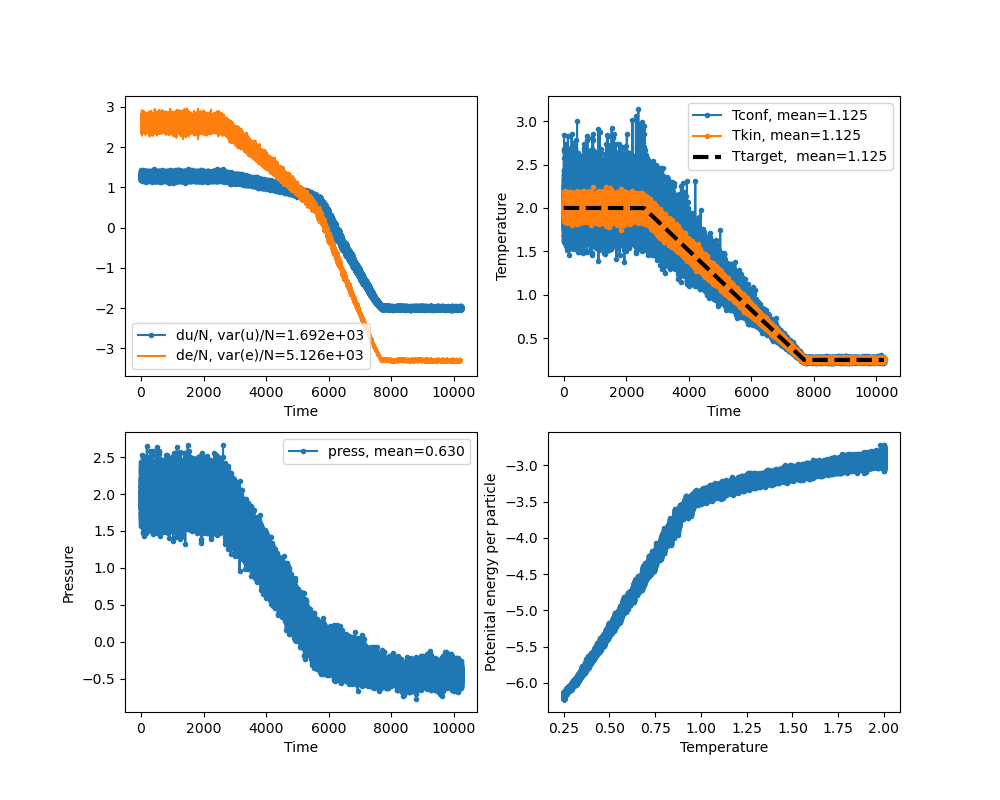

In [51]:
with open('Data/LJ_pdict.pkl', 'rb') as f:
    pdict = pickle.load(f)
df = pd.read_csv('Data/LJ_scalars.csv', index_col=False)
#print(df)
print(df.mean())
rp.plot_scalars(df, pdict['N'],  pdict['D'], figsize=(10,8), block=True)

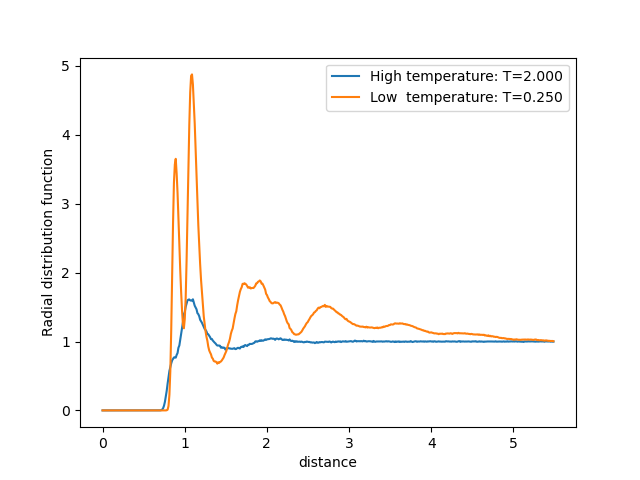

In [52]:
with open('Data/LJ_pdict.pkl', 'rb') as f:
    pdict = pickle.load(f)

if pdict['rdf']:
    rdf = np.loadtxt('Data/LJ_rdf.dat')
    plt.figure()
    plt.plot(rdf[:,0], np.mean(rdf[:, 50: 250], axis=1), label=f'High temperature: T={Thigh:.3f}')
    plt.plot(rdf[:,0], np.mean(rdf[:,800:1000], axis=1), label=f'Low  temperature: T={Tlow:.3f}')
    plt.xlabel('distance')
    plt.ylabel('Radial distribution function')
    plt.legend()
    plt.show(block=False)

In [93]:
def calc_dynamics_(conf, conf_array, block0, conf_index0, block1, conf_index1, time_index, msd, m4d):
    dR =   conf_array[block1,conf_index1,0,:,:] - conf_array[block0,conf_index0,0,:,:]
    dR += (conf_array[block1,conf_index1,1,:,:] - conf_array[block0,conf_index0,1,:,:])*conf.simbox.data
    for i in range(np.max(conf.ptype) + 1):
        msd[time_index,i] += np.mean(np.sum(dR[conf.ptype==i,:]**2, axis=1))
        m4d[time_index,i] += np.mean(np.sum(dR[conf.ptype==i,:]**2, axis=1)**2)

    return msd, m4d

def calc_dynamics(conf, conf_array, dt):
    
    num_types = np.max(conf.ptype) + 1
    num_blocks, conf_per_block = conf_array.shape[0:2]
    extra_times = int(math.log2(num_blocks))
    total_times = conf_per_block-1 + extra_times
    count = np.zeros((total_times,1), dtype=np.int32)
    msd = np.zeros((total_times, num_types))
    m4d = np.zeros((total_times, num_types))
    
    times = dt*2**np.arange(total_times)
    
    for block in range(0, num_blocks):
        for i in range(conf_per_block-1):
            count[i] += 1
            calc_dynamics_(conf, conf_array, block, i+1, block, 0, i, msd, m4d)
            
    # Compute times longer than blocks
    for block in range(0, num_blocks):
        for i in range(extra_times):
            index = conf_per_block-1 + i 
            other_block = block + 2**(i+1)            
            if other_block < num_blocks:
                count[index] += 1
                calc_dynamics_(conf, conf_array, other_block, 0, block, 0, index, msd, m4d)
 
    msd /= count
    m4d /= count
    alpha2 = 3*m4d/(5*msd**2) - 1 
    return {'times':times, 'msd':msd, 'alpha2':alpha2, 'count':count}

In [54]:
%%time
if memory_blocks:
    print(f'conf_blocks: {conf_blocks.shape}, {conf_blocks.nbytes/1024/1024:.2f} MB')
    dyn_high = calc_dynamics(c1, conf_blocks[ 50:250], dt) 
    dyn_low  = calc_dynamics(c1, conf_blocks[800:999], dt)

conf_blocks: (1000, 13, 2, 864, 3), 257.08 MB
CPU times: user 886 ms, sys: 768 µs, total: 887 ms
Wall time: 886 ms


In [55]:
%%time
if hdf5_blocks:
    with h5py.File("Data/LJ_trajectory.h5", "r") as f:
        dyn_high = calc_dynamics(c1, f['block'][ 50:250], dt) # dt, c1.simbox.data should be read from file
        dyn_low  = calc_dynamics(c1, f['block'][800:999], dt) # dt, c1.simbox.data should be read from file

CPU times: user 1.28 s, sys: 25.2 ms, total: 1.3 s
Wall time: 1.3 s


In [94]:
%%time
if sim.storage=='hdf5':
    with h5py.File(sim.filename+".h5", "r") as f:
        dyn_high = calc_dynamics(c1, f['block'][ 50:250], dt) # dt, c1.simbox.data should be read from file
        dyn_low  = calc_dynamics(c1, f['block'][800:999], dt) # dt, c1.simbox.data should be read from file

CPU times: user 1.25 s, sys: 33.5 ms, total: 1.28 s
Wall time: 1.28 s


In [56]:
%%time
if hdf5virtual_blocks:
    with h5py.File("Data/LJ_trajectory_vir.h5", "r") as f:
        dyn_high = calc_dynamics(c1, f['block'][ 50:250], dt) # dt, c1.simbox.data should be read from file
        dyn_low  = calc_dynamics(c1, f['block'][800:999], dt) # dt, c1.simbox.data should be read from file

CPU times: user 1.65 s, sys: 76 ms, total: 1.72 s
Wall time: 1.72 s


In [57]:
print(dyn_high.keys())
dyn_high['count'].T

dict_keys(['times', 'msd', 'alpha2', 'count'])


array([[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 198,
        196, 192, 184, 168, 136,  72]], dtype=int32)

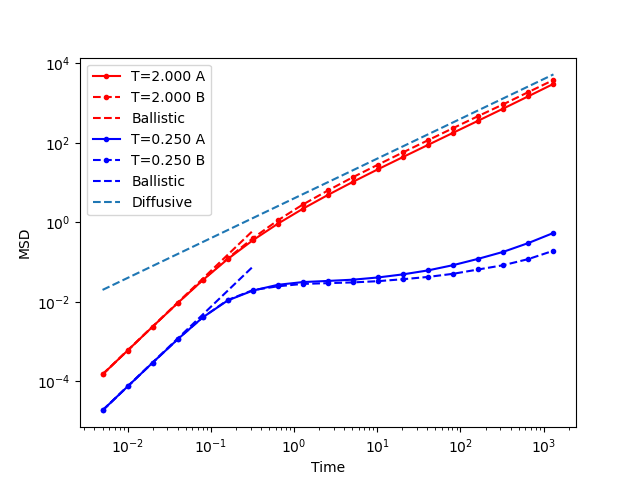

In [95]:
plt.figure()
num_types = dyn_high['msd'].shape[1]
plt.loglog(dyn_high['times'], dyn_high['msd'][:,0], 'r.-', label=f'T={Thigh:.3f} A')
if num_types>0:
    plt.loglog(dyn_high['times'], dyn_high['msd'][:,1], 'r.--', label=f'T={Thigh:.3f} B')
plt.loglog(dyn_high['times'][:7], 3*Thigh*dyn_high['times'][:7]**2, 'r--', label='Ballistic')
plt.loglog(dyn_low['times'], dyn_low['msd'][:,0], 'b.-', label=f'T={Tlow:.3f} A')
if num_types>0:
       plt.loglog(dyn_low['times'], dyn_low['msd'][:,1], 'b.--', label=f'T={Tlow:.3f} B') 
plt.loglog(dyn_low['times'][:7], 3*Tlow*dyn_low['times'][:7]**2, 'b--', label='Ballistic')
plt.loglog(dyn_low['times'], dyn_low['times']*4, '--', label='Diffusive')
plt.xlabel('Time')
plt.ylabel('MSD')
plt.legend()
plt.show()

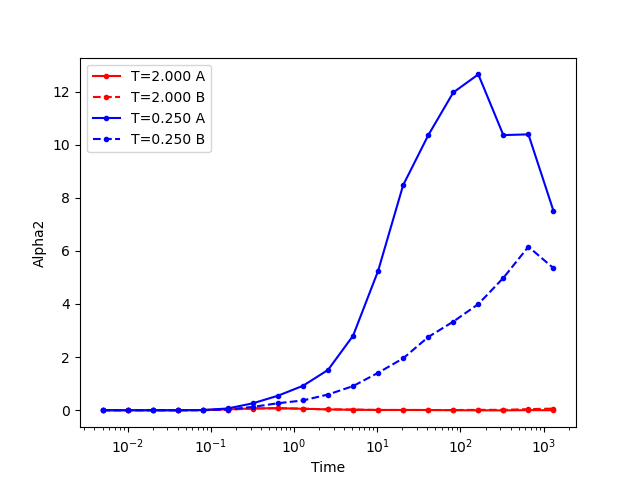

In [34]:
plt.figure()
plt.semilogx(dyn_high['times'], dyn_high['alpha2'][:,0], 'r.-', label=f'T={Thigh:.3f} A')
if num_types>0:
    plt.semilogx(dyn_high['times'], dyn_high['alpha2'][:,1], 'r.--', label=f'T={Thigh:.3f} B')
plt.semilogx(dyn_low['times'], dyn_low['alpha2'][:,0], 'b.-', label=f'T={Tlow:.3f} A') 
if num_types>0:
    plt.semilogx(dyn_low['times'], dyn_low['alpha2'][:,1], 'b.--', label=f'T={Tlow:.3f} B') 
plt.xlabel('Time')
plt.ylabel('Alpha2')
plt.legend()
plt.show()